In [1]:
! pip install selfies tensorflow_probability

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os

import deepchem as dc
from deepchem.models.normalizing_flows import NormalizingFlow, NormalizingFlowModel
from deepchem.models.optimizers import Adam
from deepchem.data import NumpyDataset
from deepchem.splits import RandomSplitter
from deepchem.molnet import load_qm9

import selfies as sf

import rdkit
from rdkit import Chem
from rdkit.Chem import Draw

from IPython.display import Image, display

import tensorflow as tf
import tensorflow_probability as tfp

tfd = tfp.distributions
tfb = tfp.bijectors
tfk = tf.keras

tfk.backend.set_floatx('float64')

c:\Users\user\OneDrive\Desktop\GitHub\small-molecules\env\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\user\OneDrive\Desktop\GitHub\small-molecules\env\lib\site-packages\torchvision\models\detection\anchor_utils.py:63: UserWarning: Failed to initialize NumPy: module compiled against API version 0x10 but this version of numpy is 0xf (Triggered internally at ..\torch\csrc\utils\tensor_numpy.cpp:77.)
  device: torch.device = torch.device("cpu"),
Skipped loading some Jax models, missing a dependency. jax requires jaxlib to be installed. See https://github.com/google/jax#installation for installation instructions.


In [3]:
tasks, datasets, transformers = load_qm9(featurizer="ECFP")
df = pd.DataFrame(data={"smiles" : datasets[0].ids})

df.head()

,smiles
0,[H]O[C@@]1(C([H])([H])[H])C(=O)N(C([H])([H])[H...
1,[H]C([H])([H])C([H])([H])C([H])([H])[C@@]1([H]...
2,[H]C1=C([H])[C@]2([H])[N@H+]3C([H])([H])[C@]2(...
3,[H]C(=O)C([H])([H])[C@]1([H])[N@H+](C2([H])C([...
4,[H]OC([H])([H])C1([C@@]2([H])C([H])([H])[C@@]2...


In [4]:
data = df[["smiles"]].sample(5000, random_state=42)

In [5]:
sf.set_semantic_constraints() # reset constraints
constraints = sf.get_semantic_constraints()
constraints["?"] = 3

sf.set_semantic_constraints(constraints)
constraints

{'H': 1,
 'F': 1,
 'Cl': 1,
 'Br': 1,
 'I': 1,
 'B': 3,
 'B+1': 2,
 'B-1': 4,
 'O': 2,
 'O+1': 3,
 'O-1': 1,
 'N': 3,
 'N+1': 4,
 'N-1': 2,
 'C': 4,
 'C+1': 5,
 'C-1': 3,
 'P': 5,
 'P+1': 6,
 'P-1': 4,
 'S': 6,
 'S+1': 7,
 'S-1': 5,
 '?': 3}

In [6]:
def process_smiles(smiles):
    return sf.encoder(smiles)

def keys_int(symbol_to_int):
    d = {}
    for i, key in enumerate(symbol_to_int.keys()):
        d[i] = key
    return d

data["selfies"] = data["smiles"].apply(process_smiles)

data["len"] = data["smiles"].apply(lambda x: len(x))
data.sort_values(by="len").head()

,smiles,selfies,len
60243,[H]C(=O)C#N,[H][C][=Branch1][C][=O][C][#N],11
101707,[H]c1nc(=O)onc1F,[H][C][=N][C][=Branch1][C][=O][O][N][=C][Ring1...,16
63373,[H]Oc1nc2onnn2n1,[H][O][C][N][=C][O][N][=N][N][Ring1][Branch1][...,16
1108,[H]C#CC#CC(=O)C#N,[H][C][#C][C][#C][C][=Branch1][C][=O][C][#N],17
105311,[H]OC([H])([H])C#N,[H][O][C][Branch1][C][H][Branch1][C][H][C][#N],18


In [7]:
selfies_list = np.asanyarray(data["selfies"])
selfies_alphabet = sf.get_alphabet_from_selfies(selfies_list)
selfies_alphabet.add("[nop]") # Ass the "no operation" symbol as a padding character
selfies_alphabet.add(".")
selfies_alphabet = list(sorted(selfies_alphabet))

largest_selfie_len = max(sf.len_selfies(s) for s in selfies_list)
symbol_to_int = dict((c, i) for i, c in enumerate(selfies_alphabet))
int_mol = keys_int(symbol_to_int)

In [8]:
onehots = sf.batch_selfies_to_flat_hot(selfies_list, symbol_to_int, largest_selfie_len)

In [9]:
input_tensor = tf.convert_to_tensor(onehots, dtype="float64")
noise_tensor = tf.random.uniform(shape=input_tensor.shape, minval=0, maxval=1, dtype="float64")
dequantized_data = tf.add(input_tensor, noise_tensor)

In [10]:
ds = NumpyDataset(dequantized_data)
splitter = RandomSplitter()
train, val, test = splitter.train_valid_test_split(dataset=ds, seed=42)
train_idx, val_idx, test_idx = splitter.split(dataset=ds, seed=42)

dim = len(train.X[0])
train.X.shape

(4000, 3380)

In [11]:
train_smiles = data['smiles'].iloc[train_idx].values

In [12]:
base_dist = tfd.MultivariateNormalDiag(loc=np.zeros(dim), scale_diag=np.ones(dim))

if dim % 2 == 0:
    permutation = tf.cast(np.concatenate((np.arange(dim / 2, dim), np.arange(0, dim / 2))), tf.int32)
else:
    permutation = tf.cast(np.concatenate((np.arange(dim / 2 + 1, dim), np.arange(0, dim / 2))), tf.int32)

In [13]:
num_layers = 8
flow_layers = []

Made = tfb.AutoregressiveNetwork(params=2, hidden_units=[521, 521], activation="relu")

for i in range(num_layers):
    flow_layers.append(
        (tfb.MaskedAutoregressiveFlow(shift_and_log_scale_fn=Made))
    )
    
    permutation = tf.cast(np.random.permutation(np.arange(0, dim)), tf.int32)
    flow_layers.append(tfb.Permute(permutation=permutation))


In [14]:

nf = NormalizingFlow(base_distribution=base_dist, flow_layers=flow_layers)

In [15]:
nfm = NormalizingFlowModel(nf, learning_rate = 1e-4, batch_size = 128)

In [16]:
losses = []
val_losses = []

In [17]:
%%time
max_epochs = 10

for epoch in range(max_epochs):
    loss = nfm.fit(train, nb_epoch=1, all_losses=losses)
    val_loss = nfm.create_nll(val.X)
    val_losses.append(val_loss.numpy())

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
CPU times: total: 1h 4min 26s
Wall time: 18min 15s


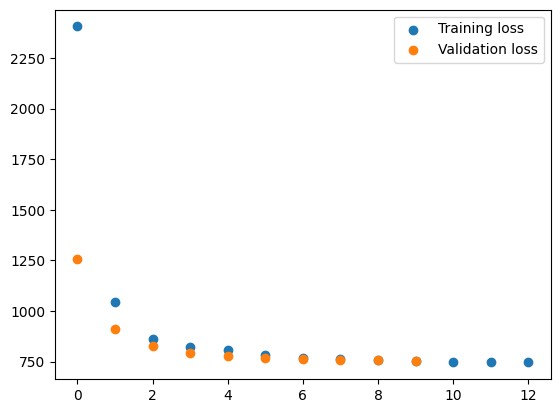

In [18]:
fig, ax = plt.subplots()
ax.scatter(range(len(losses)), losses, label = "Training loss")
ax.scatter(range(len(val_losses)), val_losses, label = "Validation loss")
plt.legend(loc="upper right")

In [19]:
generated_samples = nfm.flow.sample(20) # generaive modeling
log_probs = nfm.flow.log_prob(generated_samples) # probability density estimation

In [20]:
mols = tf.math.floor(generated_samples) # quantize data
mols = tf.clip_by_value(mols, 0, 1) # Set nefative values to 0 and values > 1 to 1

int_to_symbol = dict((i, c) for i, c in enumerate(selfies_alphabet))

# for idx, mol in enumerate(mols):
#     mol = mol.numpy().tolist()
#     print(sf.encoding_to_selfies([mol]))
    
mols = mols.numpy().tolist()
selfies_molecule = sf.encoding_to_selfies(mols, vocab_itos=int_to_symbol, enc_type="one_hot")

In [21]:
smile_molecule = sf.decoder(selfies_molecule, compatible=True)

C:\Users\user\AppData\Local\Temp\ipykernel_14196\3590359391.py:1: UserWarning: 
selfies.decoder() may behave differently than in previous major releases. We recommend using SELFIES that are up to date.
  smile_molecule = sf.decoder(selfies_molecule, compatible=True)


In [22]:
print("SELFIES: ", selfies_molecule)
print("SMILES: ", smile_molecule)

SELFIES:  [=Ring1][H][Branch2][#C][=N+1][/C][/N+1].[=O][#C][=N][/C][#C][/C][S][C@@][=N+1][#N][#N][/C@@]
SMILES:  [H]C=[N+1]/C/[N+1].O=C=N/C#C/CS[C@@]=[N+1]=NN/[C@@]


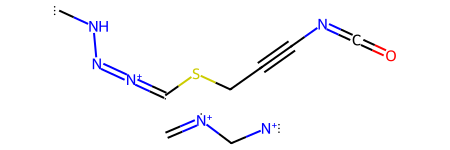

In [23]:
Chem.MolFromSmiles(sf.decoder(selfies_molecule), sanitize=True)

In [26]:
# let's generate 5 molecules

import random
int_to_symbol = dict((i, c) for i, c in enumerate(selfies_alphabet))

selfies_molecules = []

for i in range(5):
    n_steps = random.randint(10, 30)
    generated_samples = nfm.flow.sample(n_steps) # generaive modeling
    log_probs = nfm.flow.log_prob(generated_samples) # probability density estimation
    
    mols = tf.math.floor(generated_samples) # quantize data
    mols = tf.clip_by_value(mols, 0, 1) # Set nefative values to 0 and values > 1 to 1
    mols = mols.numpy().tolist()
    selfies_molecule.append(sf.encoding_to_selfies(mols, vocab_itos=int_to_symbol, enc_type="one_hot"))

: 

: 